# Detecção de Pivos De Irrigação em Imagens Coletadas de Satélites

In [2]:
!pip install rasterio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Libraries Imports
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [5]:
# Downloading test image
path_circle = '/content/drive/MyDrive/Saudi_circles.tif'

In [6]:
with rasterio.open(path_circle) as src:
  im_circle = src.read()

In [7]:
print(im_circle.shape)

(5, 1606, 2195)


The image has:

5 bands of colors
1606 rows ( Vertical )
2195 columns ( Horizontal )


In [8]:
im_circle = im_circle.transpose([1,2,0])
# Reordering the axes for simpler plotting later.

In [10]:
print(im_circle.shape)

(1606, 2195, 5)


In [11]:
# Generating a NDVI image of the area
nir = im_circle[:,:,4] # Infrared
red = im_circle[:,:,2] # Red

In [12]:
ndvi_circles = (nir - red) / (nir + red) #NDVI formula

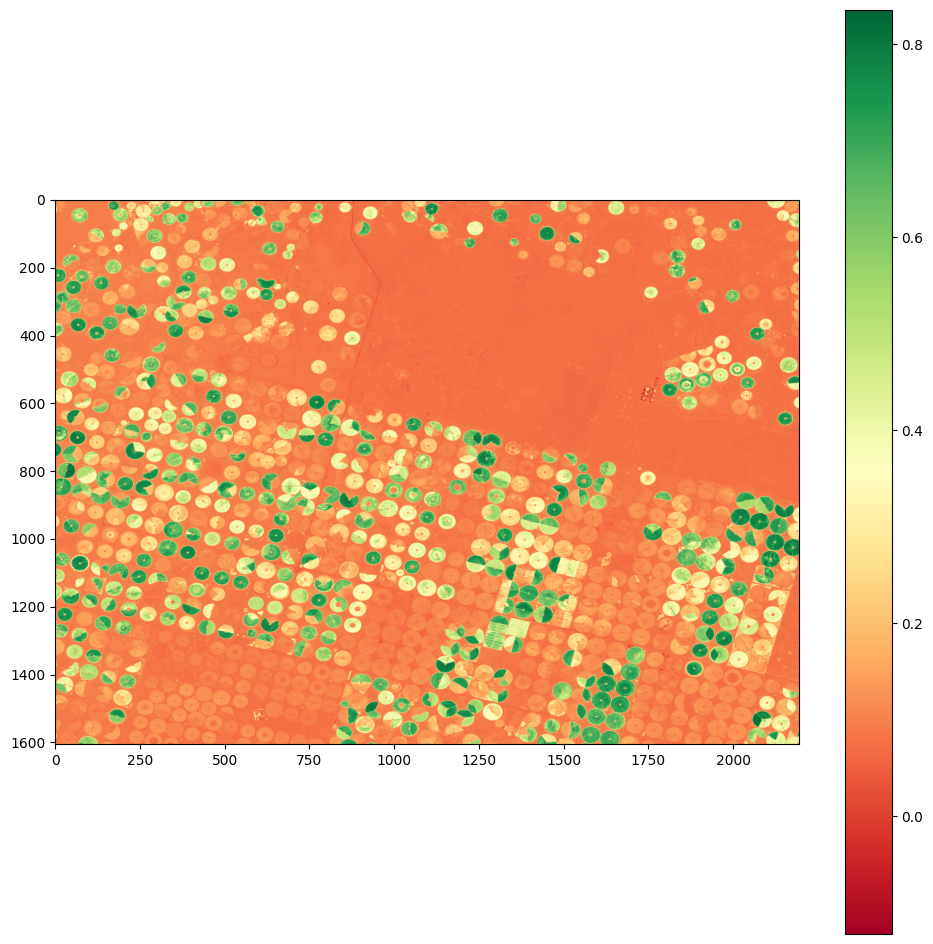

In [13]:
plt.figure(figsize=[12,12])
plt.imshow(ndvi_circles, cmap='RdYlGn')
plt.colorbar()

Green values indicate areas with more vegetation, while red ones show areas with less vegetation

First, we need to filter the image to remove noise. Then, we will normalize the image values to the range of -1 to 1 and 0 to 1

In [15]:
ndvi_circles = cv2.GaussianBlur(ndvi_circles, (3,3),0);
# Removing noise

In [16]:
ndvi_c_rescaled = cv2.normalize(ndvi_circles, None, alpha = 0, beta = 1, norm_type= cv2.NORM_MINMAX)

NDVI images typically have values in the range of -1 to 1. However, for visual computing with most OpenCV algorithms, integer values in the range of 0-255 are commonly used. Here, we are converting values from the -1 to 1 range to 0 to 1.

In [17]:
ndvi_c_rescaled = ndvi_c_rescaled * 255
# Rescaling

In [19]:
ndvi_c_rescaled = ndvi_c_rescaled.astype('uint8')
# Instead of ndvi with range of -1 to 1 now we have ndvi with the range of 0 to 255

Now, we will use the Canny function to generate borders in the image

In [20]:
edges_circle = cv2.Canny(ndvi_c_rescaled, 100, 200)

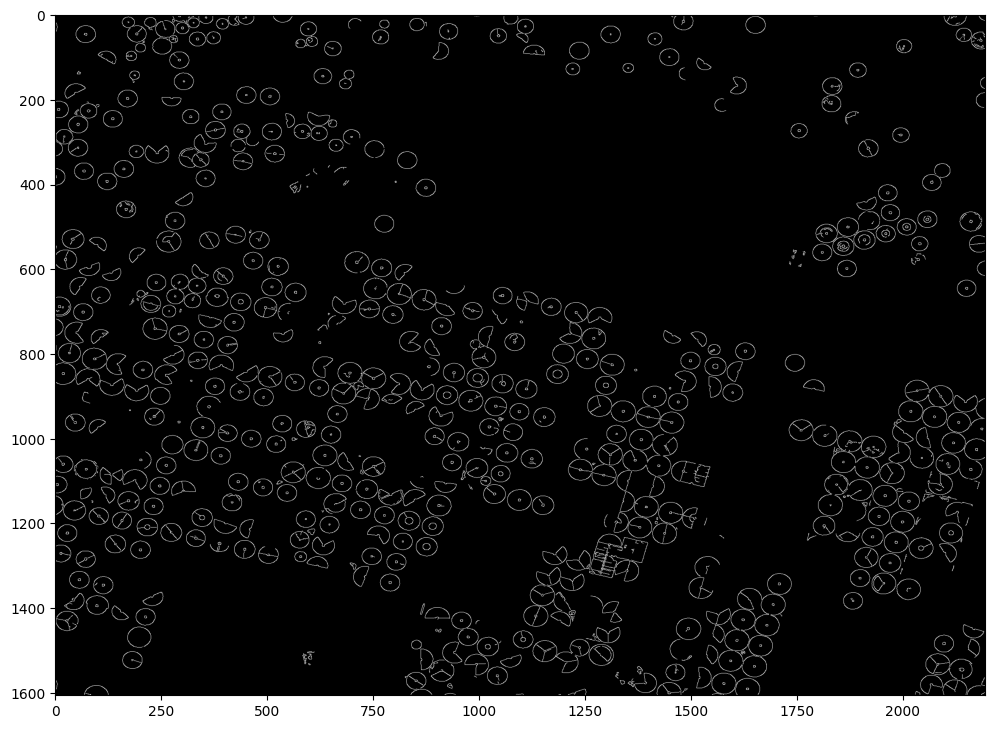

In [21]:
plt.figure(figsize=[12,12])
plt.imshow(edges_circle, cmap = 'gray')

Now, applying the color map RdYlGn, we will convert the NDVI image to a RGB one.

In [22]:
cm = plt.get_cmap('RdYlGn')
output = cm(ndvi_c_rescaled)

In [23]:
output = output[:,:,0:3] * 255

Now converting to uint8 we got the same image but colored

In [25]:
rgb_image = output.astype(np.uint8)

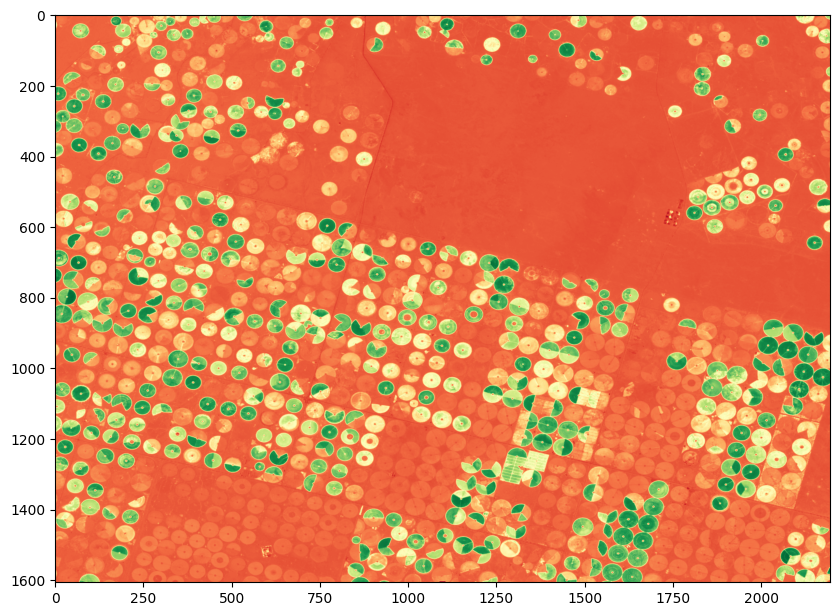

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Now, we will apply the CHT in the image with borders

In [27]:
circles = cv2.HoughCircles(edges_circle, cv2.HOUGH_GRADIENT,1,20, param1=300, param2=20, minRadius = 10, maxRadius = 30)

Now we plot in tha NDVI RGB image the circles found in the image

In [28]:
if circles is not None:
  # Convert the (x, y) coords and radius of the circles to integers
  circles = np.round(circles[0,:]).astype('int')
  for (x,y,r) in circles:
    # drawing the cricles and rectangles
    cv2.circle(rgb_image, (x,y), r, (0,0,0), 4)
    cv2.rectangle(rgb_image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

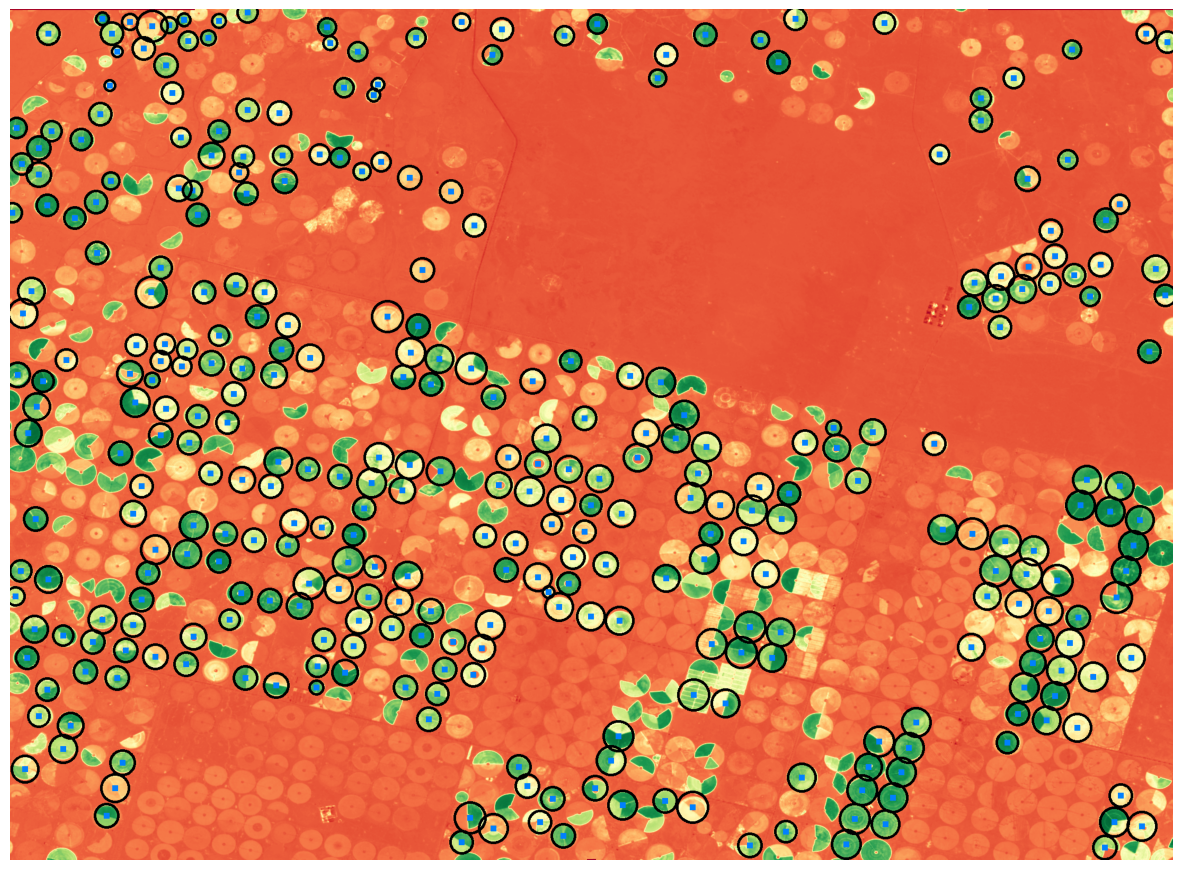

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

 Convert the central points into latitude and longitude coordinates

In [32]:
from osgeo import osr, ogr, gdal
import pandas as pd
import geopandas as gpd
from rasterio.plot import show

Creating some auxiliary functions

In [40]:
#Converting rows and cols to lat and lon
def pixel_to_world(geo_matrix, x, y):
  ul_x = geo_matrix[0]
  ul_y = geo_matrix[3]
  x_dist = geo_matrix[1]
  y_dist = geo_matrix[5]
  _x = x * x_dist + ul_x
  _y = y * y_dist + ul_y
  return _x, _y

def build_transform_inverse(dataset, EPSG):
  source = osr.SpatialReference(wkt = dataset.GetProjection())
  target = osr.SpatialReference()
  target.ImportFromEPSG(EPSG)
  return osr.CoordinateTransformation(source,target)

def find_spatial_coordinate_from_pixel(dataset, transform, x, y):
  world_x, world_y = pixel_to_world(dataset.GetGeoTransform(), x, y)
  point = ogr.Geometry(ogr.wkbPoint)
  point.AddPoint(world_x, world_y)
  point.Transform(transform)
  return point.GetX(), point.GetY()

In [36]:
ds = gdal.Open('/content/drive/MyDrive/Saudi_circles.tif')

 Obtaining geo transforms using EPSG:4326

In [37]:
_t = build_transform_inverse(ds, 4326)

Converting each point found and adding it to a dataframe representing coordinates


In [41]:
ls_x = []
ls_y = []
for (x,y,r) in circles:
  coordinates = find_spatial_coordinate_from_pixel(ds, _t, x, y)
  ls_x.append(coordinates[0])
  ls_y.append(coordinates[1])

In [43]:
df_xy = pd.DataFrame([])
df_xy['x'] = ls_x
df_xy['y'] = ls_y

Using GeoPandas to create a GeoDataFrame with the obtained data


In [44]:
gdf = gpd.GeoDataFrame(df_xy, geometry = gpd.points_from_xy(df_xy['x'], df_xy['y']))

In [47]:
gdf = gdf.set_crs(src.crs)

In [48]:
gdf

x          y                   geometry
0    38.297157  30.128956  POINT (38.29716 30.12896)
1    38.324825  30.113145  POINT (38.32482 30.11315)
2    38.208044  30.196150  POINT (38.20804 30.19615)
3    38.272363  30.191119  POINT (38.27236 30.19112)
4    38.226729  30.259032  POINT (38.22673 30.25903)
..         ...        ...                        ...
335  38.127196  30.357846   POINT (38.1272 30.35785)
336  38.485084  30.286700   POINT (38.48508 30.2867)
337  38.173908  30.382640  POINT (38.17391 30.38264)
338  38.129711  30.369345  POINT (38.12971 30.36934)
339  38.217027  30.194712  POINT (38.21703 30.19471)

[340 rows x 3 columns]

<Axes: >

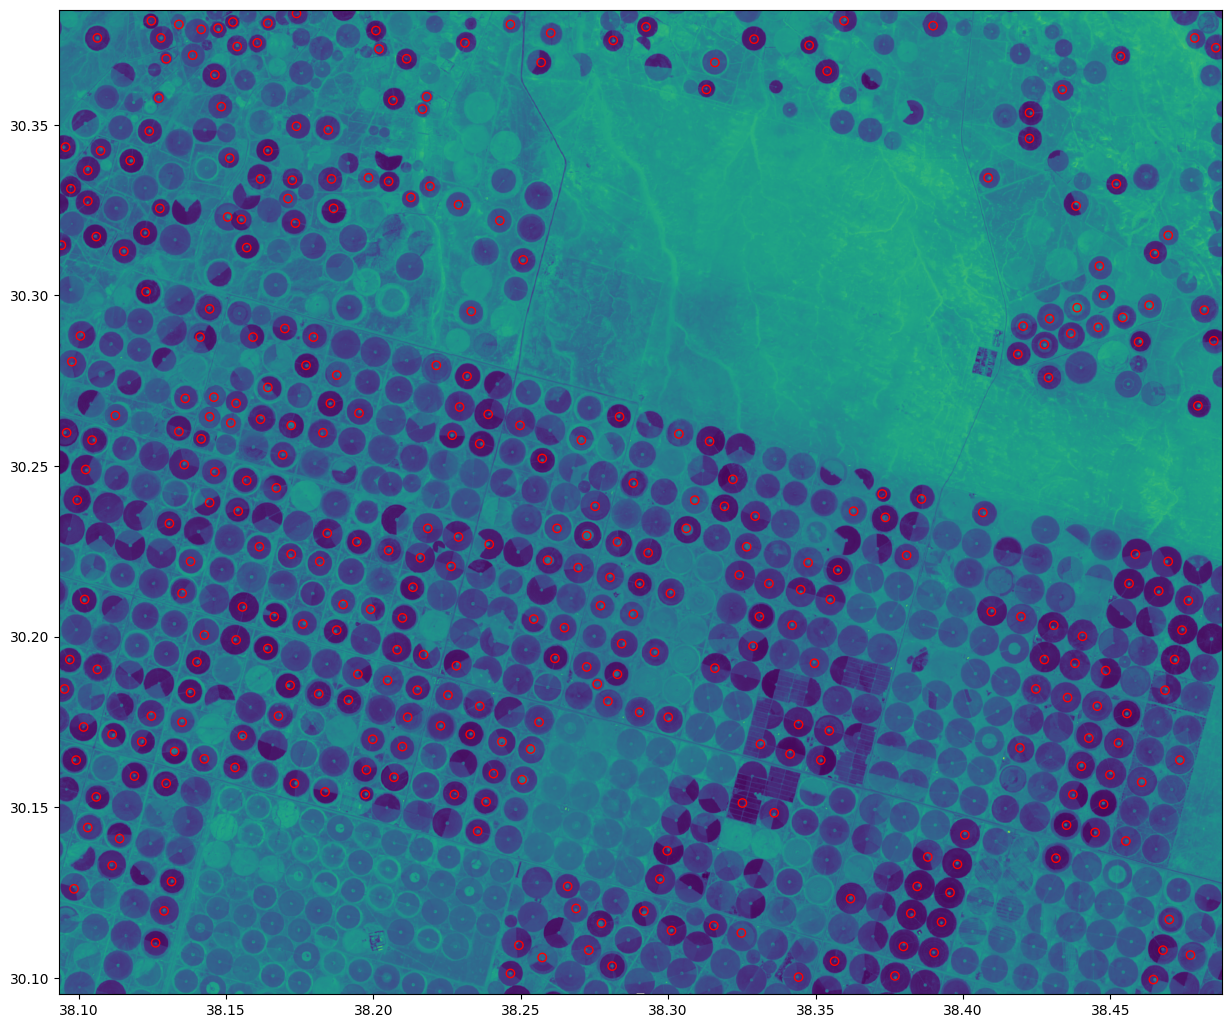

In [50]:
src = rasterio.open(path_circle)
fig, ax = plt.subplots(figsize=(15,15))
show((src, 4), ax = ax)
gdf.plot(ax=ax, facecolor='none', edgecolor='red')

We can also save in a shapefile and download it

In [51]:
if not os.path.isdir('/content/shapefile'):
  os.mkdir('/content/shapefile')

In [52]:
gdf.to_file("/content/shapefile/Saudi-Pivos.shp")

In [55]:
!zip -r /content/shapefile.zip /content/shapefile
from google.colab import files
files.download("/content/shapefile.zip")

  adding: content/shapefile/ (stored 0%)
  adding: content/shapefile/Saudi-Pivos.dbf (deflated 66%)
  adding: content/shapefile/.ipynb_checkpoints/ (stored 0%)
  adding: content/shapefile/Saudi-Pivos.shp (deflated 44%)
  adding: content/shapefile/Saudi-Pivos.prj (deflated 17%)
  adding: content/shapefile/Saudi-Pivos.cpg (stored 0%)
  adding: content/shapefile/Saudi-Pivos.shx (deflated 72%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>